## Inhaltsverzeichnis
- [Einleitung](#1)<br>
- [Benötigte Imports](#2)<br>
- [Laden der Datensätze](#3)<br>
- [Data Preprocessing](#4)<br>
- [Exploratory Data Analysis (EDA)](#5)<br>
- [Datensatz für die Experimente](#6)<br>
- [Feature Engineering](#7)<br>
- [1. Experiment mit LSTM](#8)<br>
- [2. Experiment mit Transformer](#9)<br>
- [3. Experiment mit KNN](#10)<br>
- [Fazit](#11)<br>

<a id="1"></a>
## Einleitung

TO-DO:
- Related Work etc zusammenfassen.

<a id="2"></a>
## Benötigte Imports

Im folgenden werden über die requirement.txt alle, für dieses Notebook benötigten Bibliotheken in den gewählten Kernal installiert, sollten diese nicht vorhanden sein. Zudem werden alle Imports hinterlegt, sowie ein Seed gesetzt für die Wiederholbarkeit der Ergebnisse des Notebooks.

In [4]:
%pip install -r requirements.txt


import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTE
from textblob import TextBlob


import nltk
from nltk.corpus import stopwords
import re

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from itertools import combinations

# Skit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier



# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional, Concatenate, Input
from tensorflow.keras.utils import to_categorical


import torch as th


Note: you may need to restart the kernel to use updated packages.


Setzen des Seeds:

In [5]:
import random
SEED = 49
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
th.random.set_seed(SEED)
print("Der gewählte Seed ist: ", SEED)

Der gewählte Seed ist:  49


Inizieren eines Label-Encoders:

In [6]:
label_encoder = LabelEncoder()

## Utils

Funktion um die History der Modelle zu plotten:

In [7]:
# Helper function to plot the history of a model
def plot_history(history):
    print(history.history.keys())
    epochs = range(1, len(history.history['accuracy']) + 1)
    # summarize history for accuracy
    plt.plot(epochs, history.history['accuracy'], 'o-', label='Training accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'o-', label='Validation accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend(loc='upper left')
    plt.show()
    # summarize history for loss, start from second epoch, cause the first is always too high
    plt.plot(epochs[1:], history.history['loss'][1:], 'o-', label='Training loss')
    plt.plot(epochs[1:], history.history['val_loss'][1:], 'o-', label='Validation loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs[1:])  # Adjust x-axis to start from second epoch
    plt.legend(loc='upper left')
    plt.show()

<a id="3"></a>
## Laden der Datensätze

Bei den Stammdaten die für dieses Notebook verwendet wurde, handelt es sich um das Kaggle-Datenset [Song lyrics from 79 musical genres](https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres) von Anderson Neisse.<br>
Der Datensatz wurde aus dem Wunsch heraus erstellt, die Fähigkeiten im Web-Scraping zu verbessern und ein LSTM-Netzwerk zu trainieren, um möglicherweise Liedtexte zu komponieren. Die Daten wurden durch das Scraping der brasilianischen Website Vagalume mit R gewonnen. Der Datensatz enthält zwei Dateien: artists-data.csv und lyrics-data.csv, die ursprünglich Daten zu nur sechs Musikgenres enthielten. Bei der letzten Aktualisierung wurden jedoch alle Liedtexte von der Website gescraped. Die Daten stammen von Vagalume, abhängig von deren Bemühungen, Millionen von Liedtexten zu speichern und zu teilen. Die Inspiration für das Scraping dieses Datensatzes war der Wunsch, Musikdaten zu analysieren und ein LSTM-Netzwerk zum Komponieren von Liedtexten zu trainieren. [Quelle](https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres)

In [8]:
lyrics_df = pd.read_csv('data/lyrics-data.csv')
lyrics_df.head(2)

,ALink,SName,SLink,Lyric,language
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt


In [9]:
artist_df = pd.read_csv('data/artists-data.csv')
artist_df.head(2)

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/


Zusammenführen der DataFrames anhand der 'ALink' Spalte in lyrics_df und der 'Link' Spalte in artist_df:

In [10]:
df = pd.merge(lyrics_df, artist_df, left_on='ALink', right_on='Link')
df.head()

,ALink,SName,SLink,Lyric,language,Artist,Genres,Songs,Popularity,Link
0,/ivete-sangalo/,Arerê,/ivete-sangalo/arere.html,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,/ivete-sangalo/,Se Eu Não Te Amasse Tanto Assim,/ivete-sangalo/se-eu-nao-te-amasse-tanto-assim...,Meu coração\nSem direção\nVoando só por voar\n...,pt,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
2,/ivete-sangalo/,Céu da Boca,/ivete-sangalo/chupa-toda.html,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
3,/ivete-sangalo/,Quando A Chuva Passar,/ivete-sangalo/quando-a-chuva-passar.html,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
4,/ivete-sangalo/,Sorte Grande,/ivete-sangalo/sorte-grande.html,A minha sorte grande foi você cair do céu\nMin...,pt,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/


Im folgenden schauen wir uns ein paar erste Kennzahlen der Daten an:

In [11]:
len(df["Genres"].value_counts())

1747

Wir sehen dass wir insgesamt 1747 Genres im Datensatz haben.<br>
Die Frage die sich uns stellt ist wie sehen diese Genres aus?

In [12]:
df["Genres"].value_counts()

Genres
Gospel/Religioso                            20095
Sertanejo                                   10847
Rock                                         5870
Romântico                                    5233
Forró                                        5114
                                            ...  
Rap; Hip Hop; Infantil                          1
Progressivo; House; Electronica                 1
Pop/Rock; Classic Rock; Gospel/Religioso        1
Rap; Gospel/Religioso                           1
Funk Carioca; Blues                             1
Name: count, Length: 1747, dtype: int64

Wir können erkennen dass das Genre dass am öftesten Vorkommt das Genre Gospel/Religioso mit insgesmant 20095 Lyrics ist. Was wir zudem sehen können ist dass anscheinend Lyrics auch mehrfach gelabelt wurden (Progressivo; House; Electronica). Dies ist für aber nicht überraschend, da wir in unserer rechechere ergeben hat lassen sich lieder auch nicht immer eindeutig einem Genre zuweisen. Genres haben viele Subgenres und es gibt fließende Grenzen.


Wie viele Sprachen existieren im Datensatz und wie sehen diese aus?

In [13]:
print("Anzahl an Sprachen in den Daten:",len(df["language"].value_counts()))
df["language"].value_counts()


Anzahl an Sprachen in den Daten: 51


language
en     191387
pt     156941
es       9916
rw       1679
it       1426
fr       1221
de        843
fi        145
sv        112
ro         97
no         89
is         86
tl         69
pl         47
gl         36
ga         32
tr         32
id         26
cy         23
su         19
af         19
sw         19
ko         17
nl         14
da         13
ca         13
et         12
ms          8
ja          7
st          6
ht          5
ar          4
ru          4
eu          4
gd          4
cs          3
ku          3
ny          3
mg          3
lg          2
jw          2
hu          2
iw          1
sr          1
hmn         1
hr          1
vi          1
fa          1
sq          1
zh          1
sl          1
Name: count, dtype: int64

Wir haben uns entschieden, uns nur auf englische Lyrics zu konzentrieren und alle Lyrics in anderen Sprachen zu ignorieren:

In [14]:
df = df[df["language"] == "en"]

<a id="4"></a>
## Data Preprocessing

In diesem Kapitel schauen wir uns den Datensatz an und bereinigen diesen so, dass wir im folgenden mit der Exploratory Data Analysis (EDA) fortfahren können.

Im ersten Schritt entfernen wir alle für dieses Notebook irelevanten Spalten (Features) unseres Datensatzes und bennen die Features, die uns interessieren um:

In [15]:
df = df.drop(["ALink","SLink", "Songs", "Popularity", "Link", "language"], axis=1)
df.rename(columns={'SName': 'Titel'}, inplace=True)
df.head(5)

,Titel,Lyric,Artist,Genres
69,Careless Whisper,I feel so unsure\nAs I take your hand and lead...,Ivete Sangalo,Pop; Axé; Romântico
86,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya\nOr even try to school...",Ivete Sangalo,Pop; Axé; Romântico
88,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here\nDon't be c...",Ivete Sangalo,Pop; Axé; Romântico
111,Easy,"Know it sounds funny\nBut, I just can't stand ...",Ivete Sangalo,Pop; Axé; Romântico
140,For Your Babies (The Voice cover),You've got that look again\nThe one I hoped I ...,Ivete Sangalo,Pop; Axé; Romântico


Die Länge des daraus entstanden Dataframes beträgt:

In [16]:
len(df)

191387

Die Anzahl der Nullwerte des Dataframes lauten wie folgt:

In [17]:
df.isna().sum()

Titel     2
Lyric     0
Artist    0
Genres    9
dtype: int64

Auf Grund der Menge unserer Daten haben wir uns dafür entschieden alle Songs bei denen uns die Genre (Labels) fehlen aus dem Datensatz zu entfenren:

In [18]:
df = df.dropna(subset=['Genres'])
df.isna().sum()

Titel     2
Lyric     0
Artist    0
Genres    0
dtype: int64

Wenn wir uns die Daten genau anschauen fällt auf, dass in den Lyrics sehr oft \n und \t zu finden war. Dieser Sachbestant ist höchstwahrscheinlich beiom Scrapen der Daten entstanden. Im Folgenden werden wir diese nun entfernen:

In [19]:
df['Lyric'] = df['Lyric'].str.replace('\n', ' ', regex=False)
df['Lyric'] = df['Lyric'].str.replace('\t', ' ', regex=False)
df.head(5)

,Titel,Lyric,Artist,Genres
69,Careless Whisper,I feel so unsure As I take your hand and lead ...,Ivete Sangalo,Pop; Axé; Romântico
86,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya Or even try to school,...",Ivete Sangalo,Pop; Axé; Romântico
88,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here Don't be co...",Ivete Sangalo,Pop; Axé; Romântico
111,Easy,"Know it sounds funny But, I just can't stand t...",Ivete Sangalo,Pop; Axé; Romântico
140,For Your Babies (The Voice cover),You've got that look again The one I hoped I h...,Ivete Sangalo,Pop; Axé; Romântico


Mit der Folgenden Funktionen führen wir die folgenden Preprocess-Schritte durch:
- Lowercasing
- Entfernung von Zahlen oder Umwandlung in Text
- Entfernung von Satzzeichen
- Entfernung von Stoppwörtern

In [20]:
# Sicherstellen, dass NLTK-Ressourcen heruntergeladen sind
nltk.download('stopwords')


# Funktion zur Bereinigung des Lyrics-Textes
def clean_lyrics(text):
    # Lowercasing
    text = text.lower()
    # Entfernung von Zahlen
    text = re.sub(r'\d+', '', text)
    # Entfernung von Satzzeichen
    text = re.sub(r'[^\w\s]', '', text)
    # Entfernung von mehrfachen Leerzeichen
    text = re.sub(r'\s+', ' ', text)
    # Entfernung von Stoppwörtern
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Entfernung von Wiederholungen wie "yeah yeah yeah"
    return text

# Anwendung der Bereinigungsfunktion auf die Spalte 'lyrics'
df['Lyric'] = df['Lyric'].apply(clean_lyrics)
df.head(5)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Titel,Lyric,Artist,Genres
69,Careless Whisper,feel unsure take hand lead dance floor music d...,Ivete Sangalo,Pop; Axé; Romântico
86,Could You Be Loved / Citação Musical do Rap: S...,dont let fool ya even try school ya oh weve go...,Ivete Sangalo,Pop; Axé; Romântico
88,Cruisin' (Part. Saulo),baby lets cruise away dont confused way clear ...,Ivete Sangalo,Pop; Axé; Romântico
111,Easy,know sounds funny cant stand pain girl im leav...,Ivete Sangalo,Pop; Axé; Romântico
140,For Your Babies (The Voice cover),youve got look one hoped lad face beaming smil...,Ivete Sangalo,Pop; Axé; Romântico


Da wir nun immer noch dass Problem haben, dass wir in unseren Daten Lyrics haben, denen mehr als ein Genre (Label) zugewiesen wurde (siehe oben), haben wir uns dafür entschieden diese Lyrics aus unserem Datensatz zu entfernen und eventuell später noch Mal zu verarbeiten.

In [21]:
single_genre_df = df[df['Genres'].str.count(';') < 1]
single_genre_df.head()

,Titel,Lyric,Artist,Genres
1719,I Miss Her,oh lord id like know thinks oh oh lord wanna g...,Olodum,Axé
1766,They Don't Care About Us,skin head dead head everybody gone bad situati...,Olodum,Axé
2586,Loved You Right Away,moment saw minute met wonderful feeling never ...,Carlinhos Brown,Axé
2627,Goodbye Hello,alone time feel blues way inventions invention...,Carlinhos Brown,Axé
2640,Mess In The Freeway,wanna tell wonderful things wanna tell interes...,Carlinhos Brown,Axé


Die Länge dieses neuen Datensatzes ist nun:

In [22]:
len(single_genre_df)

42760

Abschließend stellen wir sicher dass Lyrics und Genre auch wirklich strings sind:

In [23]:
single_genre_df['Lyric'] = single_genre_df['Lyric'].astype(str)
single_genre_df['Genres'] = single_genre_df['Genres'].astype(str)

Nach dem Preprocessing der Daten haben wir einen Datensatz mit insgesamt 42760 englischen Lyrics und eindeutigem Label. Mit diesen Daten werden wir nun die EDA durchführen.

<a id="5"></a>
## Exploratory Data Analysis (EDA)

Das erste was wir uns anschauen wollen ist die Verteilung der Genres:

In [24]:
len(single_genre_df["Genres"].value_counts())

61

Insgesamt haben wir in unseren Daten derzeit 61 Labels

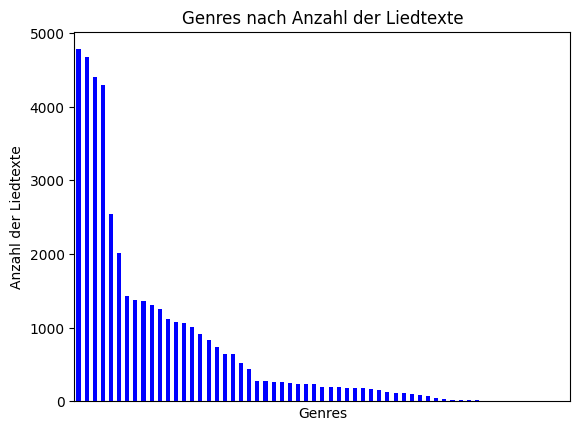

In [25]:
plot_df = single_genre_df.groupby('Genres')['Lyric'].count().sort_values(ascending=False)

plot_df.plot(kind='bar', color='blue', title='Genres nach Anzahl der Liedtexte')

plt.xlabel('Genres')
plt.ylabel('Anzahl der Liedtexte')
plt.xticks([])
plt.show()


Der obere Plot zeigt die Verteilung der unterschiedlichen Genres über Ihre anzahl an Songs. Wir sehen eine starke Class-Imbalancing

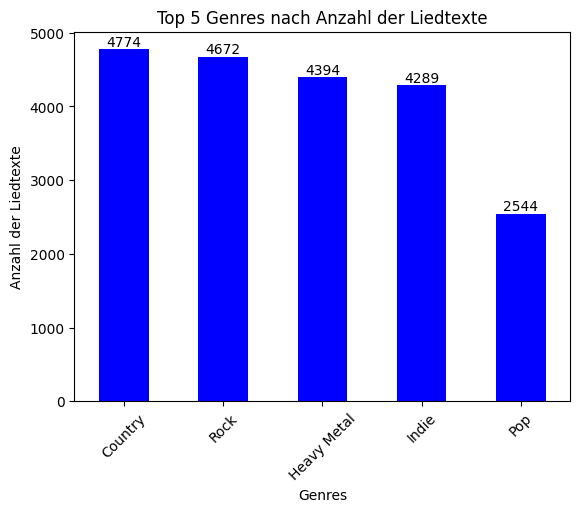

In [26]:
plot_df = single_genre_df.groupby('Genres')['Lyric'].count().sort_values(ascending=False).head(5)

ax = plot_df.plot(kind='bar', color='blue', title='Top 5 Genres nach Anzahl der Liedtexte')

plt.xlabel('Genres')
plt.ylabel('Anzahl der Liedtexte')
plt.xticks(rotation=45)

for i, value in enumerate(plot_df):
    ax.text(i, value, str(value), ha='center', va='bottom')

plt.show()


Selbst unter den 5 Genres mit der höhsten Anzahl an Lyrics finden wir eine größe Classimbalance. Existieren fast doppelt so viele Country-Songs als Pop-Songs im Datensatz. 

Im Folgenden vollen wir die Lyrics an sich etwas genauer analysieren. Hierfür entwickeltn wir zwei Features: Lyric_Count und Count_Norm. Bei dem Feature Lyric_Count handelt es sich um die Summe der Wörter in der Lyrics. Dieses Feature wurde daraufhin für Count_Norm normalisiert.

In [27]:
single_genre_df['Lyric_Count'] = single_genre_df['Lyric'].map(lambda x: len(x.split()))
single_genre_df['Count_Norm'] = single_genre_df['Lyric_Count'] / single_genre_df['Lyric_Count'].max()
single_genre_df['Count_Norm'] = single_genre_df['Count_Norm'].map(lambda x: x*55)
single_genre_df.head(2)

,Titel,Lyric,Artist,Genres,Lyric_Count,Count_Norm
1719,I Miss Her,oh lord id like know thinks oh oh lord wanna g...,Olodum,Axé,63,2.547794
1766,They Don't Care About Us,skin head dead head everybody gone bad situati...,Olodum,Axé,265,10.716912


Im folgenden wollen wir uns das Lyric-Count Feature genuer anschauen und herrausfinden ob es einen signifikanten unterschied gibt zwischen der Anzahl an Wörter und Genre in dem sich die Lyrics befindet:

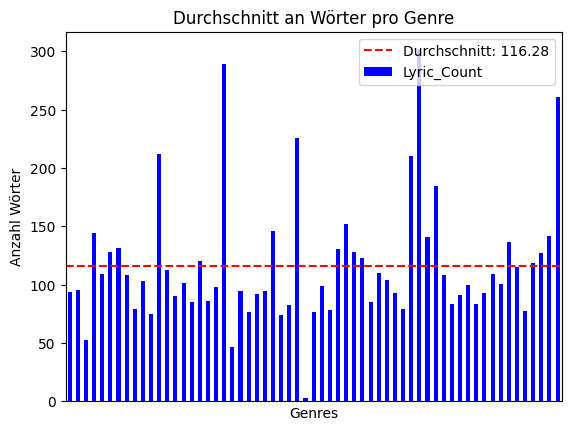

In [28]:

plot_df = single_genre_df.groupby('Genres')['Lyric_Count'].mean()

ax = plot_df.plot(kind='bar', color='blue', title='Durchschnitt an Wörter pro Genre')

plt.xlabel('Genres')
plt.ylabel('Anzahl Wörter')
plt.xticks([])  

overall_mean = plot_df.mean()

plt.axhline(y=overall_mean, color='red', linestyle='--', label=f'Durchschnitt: {overall_mean:.2f}')

plt.legend()

plt.show()


Wie wir in diesem Plot sehen können bestehen unsere Lyrics im Schnitt aus 116.28 Wörter. Zudem haben wir extreme Ausreiser. 

Die 10 Genres mit dem meisten Wörtern im Schnitt lauten:

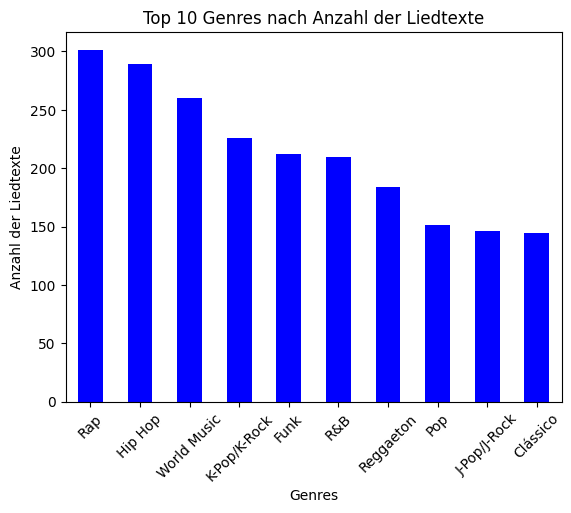

In [29]:
plot_df = single_genre_df.groupby('Genres')['Lyric_Count'].mean().sort_values(ascending=False).head(10)

ax = plot_df.plot(kind='bar', color='blue', title='Top 10 Genres nach Anzahl der Liedtexte')

plt.xlabel('Genres')
plt.ylabel('Anzahl der Liedtexte')
plt.xticks(rotation=45)

plt.show()

Die 10 Genres mit dem wenigsten Wörtern im Schnitt lauten:

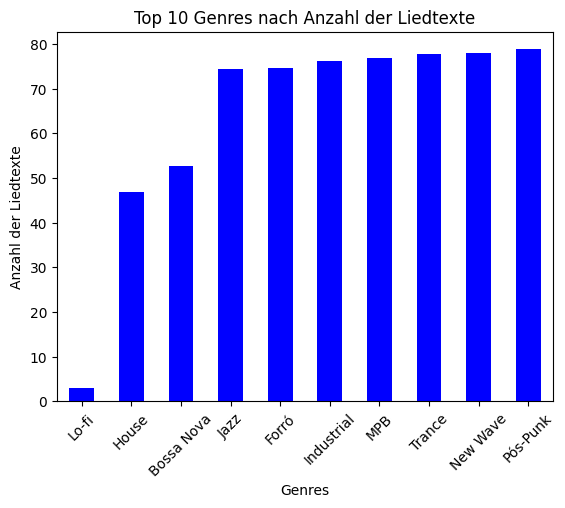

In [30]:
plot_df = single_genre_df.groupby('Genres')['Lyric_Count'].mean().sort_values(ascending=True).head(10)

ax = plot_df.plot(kind='bar', color='blue', title='Top 10 Genres nach Anzahl der Liedtexte')

plt.xlabel('Genres')
plt.ylabel('Anzahl der Liedtexte')
plt.xticks(rotation=45)

plt.show()

So haben die Genres Rap und Hip/Hop dies meisten Wörter in ihren Lyrics wohingegen Lo-fi mit Abstand am wenigsten Wörter pro Song hat.

Da sich die Genres in Ihren Lyrics von der Anzahl der Wörter stark unterscheiden, haben wir uns dafür entschieden erst Mal nur die 20 Genres mit den meisten Wörtern pro Lyric fortzufahren.
Um Class-Imbalance in der Analyse vorzubeugen haben wir uns dafür entschieden von den Top 20 Genre jeweils 500 Samples zu verwenden 

In [31]:
num_samples = 500
num_genres = 20

analysis_df = single_genre_df.copy()
top_genres = analysis_df['Genres'].value_counts().nlargest(num_genres).index

# Filter the DataFrame to only include rows with the top five genres
analysis_df = analysis_df[analysis_df['Genres'].isin(top_genres)]

def sample_or_skip(group):
    return group.sample(n=num_samples, random_state=SEED) if len(group) >= num_samples else None

analysis_df = analysis_df.groupby('Genres').apply(sample_or_skip).reset_index(drop=True)


# Now df_top_genres contains only the rows where the genre is one of the top five
print(analysis_df['Genres'].value_counts())

Genres
Blues               500
Country             500
Soft Rock           500
Romântico           500
Rockabilly          500
Rock                500
Reggae              500
Rap                 500
Punk Rock           500
Pop/Rock            500
Pop                 500
Jazz                500
Indie               500
Hip Hop             500
Heavy Metal         500
Hard Rock           500
Gospel/Religioso    500
Folk                500
Electronica         500
Trilha Sonora       500
Name: count, dtype: int64


Wir schauen uns die Cosine Similarity an zwischen den Genres:

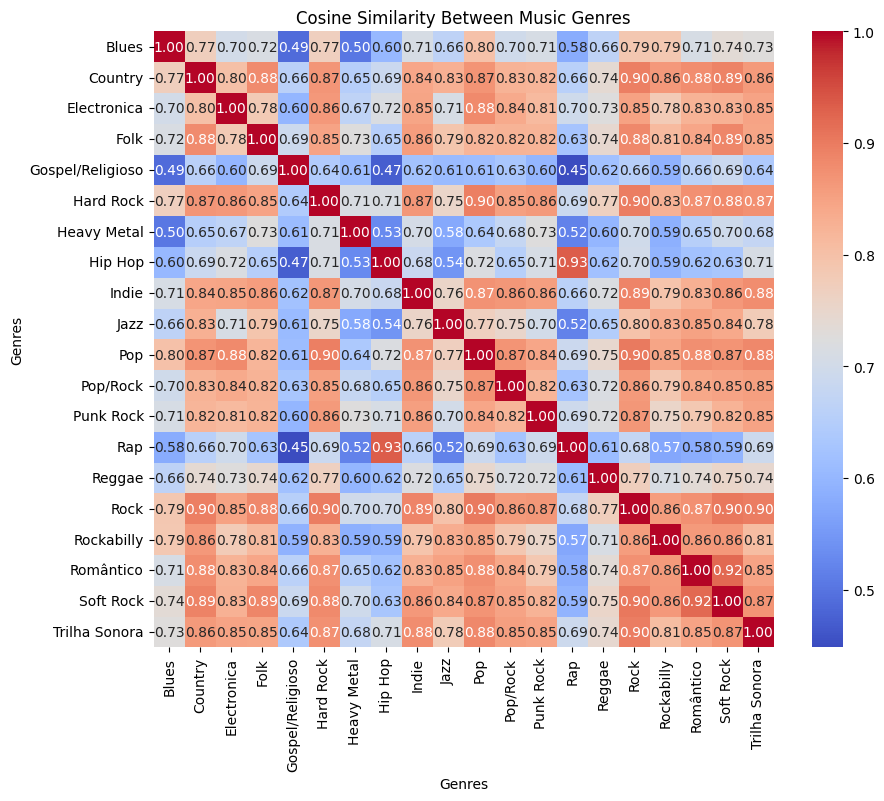

In [32]:
# Assuming df is a DataFrame with 'Lyrics' and 'Genres'
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(analysis_df['Lyric'])

# Create a DataFrame to hold genres and their TF-IDF vectors
genre_tfidf = pd.DataFrame(tfidf_matrix.toarray(), index=analysis_df['Genres'], columns=vectorizer.get_feature_names_out())

# Group by genre and calculate the mean TF-IDF score for each genre
mean_tfidf_by_genre = genre_tfidf.groupby('Genres').mean()

# Calculate the pairwise cosine similarity between genre vectors
similarity_matrix = cosine_similarity(mean_tfidf_by_genre)
similarity_df = pd.DataFrame(similarity_matrix, index=mean_tfidf_by_genre.index, columns=mean_tfidf_by_genre.index)

# Set the plot size
plt.figure(figsize=(10, 8))

# Create a heatmap to visualize the similarity matrix
sns.heatmap(similarity_df, 
            annot=True,   # Optionally add annotations to each cell
            fmt=".2f",    # Formatting the annotation if `annot` is True
            cmap='coolwarm',  # Color map style
            xticklabels=similarity_df.columns,  # Ensuring labels are genre names
            yticklabels=similarity_df.index)

# Add titles and labels for clarity
plt.title('Cosine Similarity Between Music Genres')
plt.xlabel('Genres')
plt.ylabel('Genres')

# Show the plot
plt.show()


TO-DO: Herbert muss dass beschreiben

Im nächsten Schritt wollen wir uns die Genres anschauen die am ähnlichsten und am unähnlichsten sind:

In [33]:
# Get all combinations of 5 genres
genre_combinations = list(combinations(similarity_df.index, 5))

# Function to calculate the mean similarity of a combination
def mean_similarity(combination):
    # Extract the sub-matrix of the similarity matrix for the given combination
    sub_matrix = similarity_df.loc[combination, combination]
    # Calculate the mean of the upper triangle of the matrix, excluding the diagonal
    mean_sim = np.mean([sub_matrix.iloc[i, j] for i in range(len(combination)) for j in range(i+1, len(combination))])
    return mean_sim

# Calculate mean similarity for each combination
mean_similarities = [(combo, mean_similarity(combo)) for combo in genre_combinations]

# Find the combination with the smallest mean similarity
min_similarity_combo = min(mean_similarities, key=lambda x: x[1])

print("Combination with the smallest mean similarity:", min_similarity_combo[0])
print("Mean similarity:", min_similarity_combo[1])

# Find the combination with the smallest mean similarity
max_similarity_combo = max(mean_similarities, key=lambda x: x[1])

print("Combination with the maximum mean similarity:", max_similarity_combo[0])
print("Mean similarity:", max_similarity_combo[1])

Combination with the smallest mean similarity: ('Blues', 'Gospel/Religioso', 'Heavy Metal', 'Jazz', 'Rap')
Mean similarity: 0.5513231987323743
Combination with the maximum mean similarity: ('Hard Rock', 'Pop', 'Rock', 'Romântico', 'Soft Rock')
Mean similarity: 0.8895742921518947


TO-DO: Herbert muss dass beschreiben

Diese Zusammenhänge werden im Folgenden geplottet 

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.002s...
[t-SNE] Computed neighbors for 2500 samples in 1.048s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.332453
[t-SNE] KL divergence after 50 iterations with early exaggeration: 76.952576
[t-SNE] KL divergence after 300 iterations: 2.317718


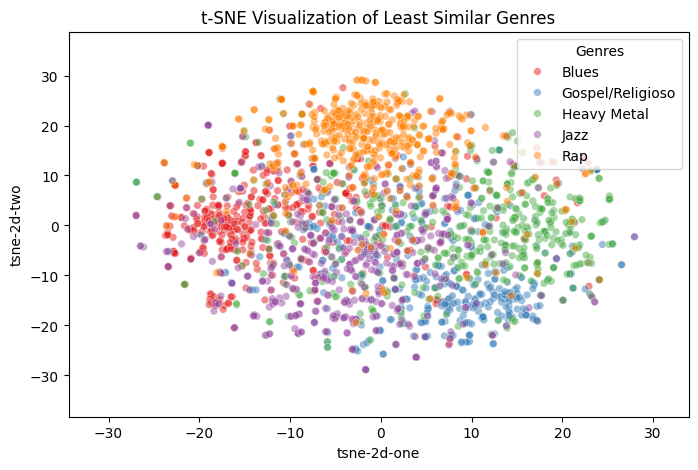

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.003s...
[t-SNE] Computed neighbors for 2500 samples in 0.109s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.399625
[t-SNE] KL divergence after 250 iterations with early exaggeration: 107.258896
[t-SNE] KL divergence after 300 iterations: 5.300963


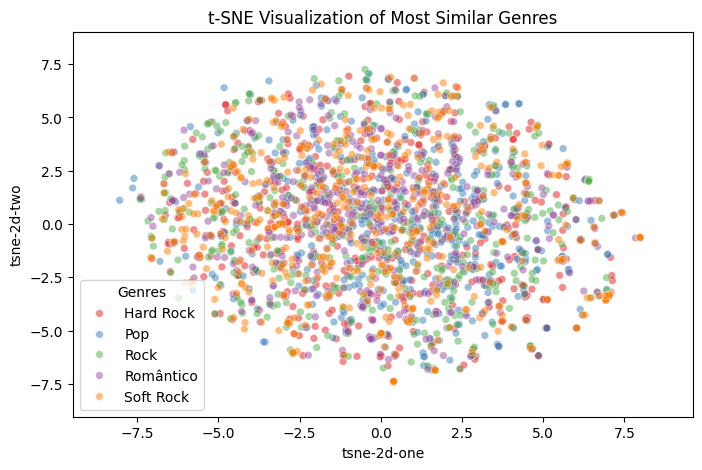

In [34]:
def plot_tsne_for_genres(df, genre_subset, title_suffix):
    # Filter the DataFrame for the genres in genre_subset
    filtered_df = df[df['Genres'].isin(genre_subset)]
    
    # Vectorize the lyrics
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(filtered_df['Lyric'])
    # Reduce dimensions
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(X.toarray())
    
    filtered_df['tsne-2d-one'] = tsne_results[:,0]
    filtered_df['tsne-2d-two'] = tsne_results[:,1]

    # Calculate IQR for scaling axis
    Q1_tsne_one = np.percentile(filtered_df['tsne-2d-one'], 25)
    Q3_tsne_one = np.percentile(filtered_df['tsne-2d-one'], 75)
    IQR_tsne_one = Q3_tsne_one - Q1_tsne_one
    Q1_tsne_two = np.percentile(filtered_df['tsne-2d-two'], 25)
    Q3_tsne_two = np.percentile(filtered_df['tsne-2d-two'], 75)
    IQR_tsne_two = Q3_tsne_two - Q1_tsne_two

    # Set axis limits
    x_min, x_max = Q1_tsne_one - 1.5 * IQR_tsne_one, Q3_tsne_one + 1.5 * IQR_tsne_one
    y_min, y_max = Q1_tsne_two - 1.5 * IQR_tsne_two, Q3_tsne_two + 1.5 * IQR_tsne_two

    # Plotting
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Genres",
        palette=sns.color_palette("Set1", len(genre_subset)),
        data=filtered_df,
        legend="full",
        s=30,
        alpha=0.5
    )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(f't-SNE Visualization of {title_suffix}')
    plt.show()
plot_tsne_for_genres(analysis_df, min_similarity_combo[0], "Least Similar Genres")
plot_tsne_for_genres(analysis_df, max_similarity_combo[0], "Most Similar Genres")

Nach all diesen Erkenntnissen haben wir uns dazu entschieden erst Mal uns auf die vier Genres 'Blues', 'Gospel/Religioso', 'Heavy Metal', 'Jazz', 'Rap' zu konzentrieren da diese sich am meisten von einander unterscheiden und daher am ehesten klassifizierbar sind.

<a id="6"></a>
## Datensatz für die Experimente

In [35]:
# Drop rows where the genre column is in the genres_to_drop list
min_similarity_df = single_genre_df[single_genre_df['Genres'].isin(min_similarity_combo[0])]
# Drop rows where the genre column is in the genres_to_drop list
max_similarity_df = single_genre_df[single_genre_df['Genres'].isin(max_similarity_combo[0])]

print("Minimum Similarity DF")
# Now df_filtered contains only the rows where genre is not 'alternative', 'r&b', 'pop/rock', or 'rock'
print(min_similarity_df['Genres'].value_counts())

print("\nMaximum Similarity DF")
# Now df_filtered contains only the rows where genre is not 'alternative', 'r&b', 'pop/rock', or 'rock'
print(max_similarity_df['Genres'].value_counts())

Minimum Similarity DF
Genres
Heavy Metal         4394
Rap                 2012
Gospel/Religioso    1431
Jazz                1356
Blues               1063
Name: count, dtype: int64

Maximum Similarity DF
Genres
Rock         4672
Pop          2544
Soft Rock    1003
Romântico     829
Hard Rock     739
Name: count, dtype: int64


TO-DO Herbert Erklärung

In [36]:
min_similarity_df.head()

,Titel,Lyric,Artist,Genres,Lyric_Count,Count_Norm
20269,At Last,last love come along lonely days life like son...,Etta James,Blues,44,1.779412
20270,I'd Rather Go Blind,something told saw talking something deep soul...,Etta James,Blues,71,2.871324
20271,Stormy Weather,dont know theres sun sky stormy weather since ...,Etta James,Blues,92,3.720588
20272,W-O-M-A-N,talkin man always ready go comes movin babe yo...,Etta James,Blues,99,4.003676
20273,Oh Happy Day,oh happy day oh happy day oh happy day oh happ...,Etta James,Blues,204,8.250000


<a id="7"></a>
## Feature Engineering

Durchschnittslänge der Worte:

In [37]:
min_similarity_df['Avg_Word_Length'] = min_similarity_df['Lyric'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if x.split() else 0)

Anzahl einzigartigen Wörter:

In [38]:
min_similarity_df['Unique_Words'] = min_similarity_df['Lyric'].apply(lambda x: len(set(x.split())))

Encodieren des Genres als Label:

In [39]:
min_similarity_df['Genre_Encoded'] = label_encoder.fit_transform(min_similarity_df['Genres'])


<a id="8"></a>
## 1. Experiment mit LSTM

Das erste was wir für dieses Experment erstellen ist ein eigener Datenframe 

In [40]:
experiment_one = min_similarity_df.copy()

Im Anschluss Class imbalancen wir diesen Dataframe indem wir down-sampling anwenden:

In [41]:
number = experiment_one['Genres'].value_counts().min()
# Erstelle einen neuen DataFrame mit gleicher Anzahl von Einträgen pro Genre
experiment_one = experiment_one.groupby('Genres').sample(n=number, random_state=SEED)
print(experiment_one["Genres"].value_counts())

Genres
Blues               1063
Gospel/Religioso    1063
Heavy Metal         1063
Jazz                1063
Rap                 1063
Name: count, dtype: int64


Anschließend splitten wir die Daten in Train, Test und Validaten Datensatz:

In [42]:
# Aufteilen der Daten in Trainings-, Validierungs- und Testsets
train_data, test_data = train_test_split(experiment_one, test_size=0.2, random_state=SEED)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=SEED)  # 0.25 * 0.8 = 0.2
print('complete:',len(experiment_one))
print('train size:',len(train_data))
print('val size:', len(val_data))
print('test size:',len(test_data))

complete: 5315
train size: 3189
val size: 1063
test size: 1063


Nun Tokenizinieren wir die Daten:

In [43]:
# Tokenizer vorbereiten und Texte zu Sequenzen umwandeln
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['Lyric'])
train_sequences = tokenizer.texts_to_sequences(train_data['Lyric'])
val_sequences = tokenizer.texts_to_sequences(val_data['Lyric'])
test_sequences = tokenizer.texts_to_sequences(test_data['Lyric'])

 Padding der Sequenzen, damit sie die gleiche Länge haben:

In [44]:
# Padding der Sequenzen, damit sie die gleiche Länge haben
max_length = max(train_data['Lyric_Count'].max(), val_data['Lyric_Count'].max(), test_data['Lyric_Count'].max())
train_padded = pad_sequences(train_sequences, maxlen=max_length)
val_padded = pad_sequences(val_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

Erstellung einer Feature-Matrix:

In [45]:
train_features = train_data[['Lyric_Count', 'Avg_Word_Length', 'Unique_Words']].values
val_features = val_data[['Lyric_Count', 'Avg_Word_Length', 'Unique_Words']].values
test_features = test_data[['Lyric_Count', 'Avg_Word_Length', 'Unique_Words']].values

Erstellen der Labels:

In [46]:
# Kodiere die Labels in One-Hot-Format
train_labels = to_categorical(train_data['Genre_Encoded'])
val_labels = to_categorical(val_data['Genre_Encoded'])
test_labels = to_categorical(test_data['Genre_Encoded'])

Erstellen eines Modells:

In [47]:
# LSTM Modell
labels = to_categorical(experiment_one['Genre_Encoded'])
input_text = Input(shape=(max_length,))
input_features = Input(shape=(3,))
embedded_text = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100)(input_text)
lstm_out = LSTM(100)(embedded_text)
concatenated = Concatenate()([lstm_out, input_features])
output = Dense(units=labels.shape[1], activation='softmax')(concatenated)
model = Model(inputs=[input_text, input_features], outputs=output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 785)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 785, 100)  │  2,739,600 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 100)       │     80,400 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 103)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5)         │        520 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,820,520 (10.76 MB)

 Trainable params: 2,820,520 (10.76 MB)

 Non-trainable params: 0 (0.00 B)

Kompilieren des Modells:

In [48]:
# Kompilieren 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

Trainieren des Modells:

In [49]:
# Modell trainieren
# history = model.fit(train_padded, train_labels, epochs=10, validation_data=(test_padded, test_labels), verbose=1, callbacks=[early_stopping])
history = model.fit([train_padded, train_features], train_labels, 
          validation_data=([val_padded, val_features], val_labels), 
          epochs=10, batch_size=32, callbacks=[early_stopping])

Epoch 1/10


100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 220ms/step - accuracy: 0.1798 - loss: 21.6015 - val_accuracy: 0.1477 - val_loss: 5.2672
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.2102 - loss: 4.4269 - val_accuracy: 0.3114 - val_loss: 2.0857
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - accuracy: 0.3587 - loss: 1.8644 - val_accuracy: 0.5532 - val_loss: 1.2792
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - accuracy: 0.6859 - loss: 1.0013 - val_accuracy: 0.7441 - val_loss: 0.7846
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.8547 - loss: 0.4748 - val_accuracy: 0.7281 - val_loss: 0.8655
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.9034 - loss: 0.3258 - val_accuracy: 0.7912 - val_loss: 0.7079
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.9400 - loss: 0.2109 - val_accuracy: 0.7883 - val_loss: 0.6912
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.9562 - loss: 0.1539 - va

Plotten der Trainings und Validation History:

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


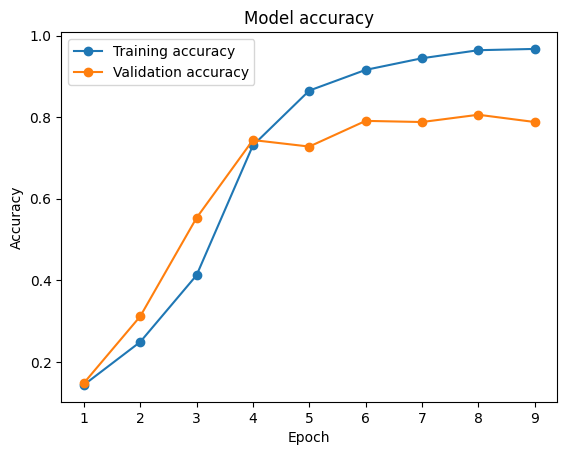

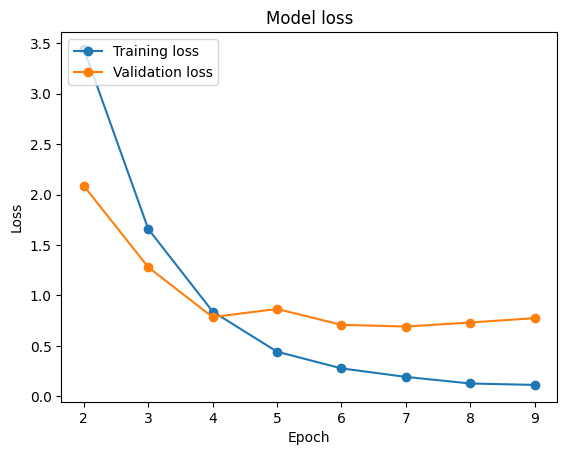

In [50]:
plot_history(history)

Testen des Modells:

In [51]:
# loss, accuracy = model.evaluate(test_padded, test_labels, verbose=1)
test_loss, test_accuracy = model.evaluate([test_padded, test_features], test_labels)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.7466 - loss: 1.1040
Test Accuracy: 74.88%
Test Loss: 1.0847


Treffen einer Vorhersage:

In [52]:
predictions = model.predict([test_padded, test_features])
predicted_labels = predictions.argmax(axis=1)

# Echte Labels für Vergleich
true_labels = test_data['Genre_Encoded'].values

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step


Erstellen einer Confucion Matrix:

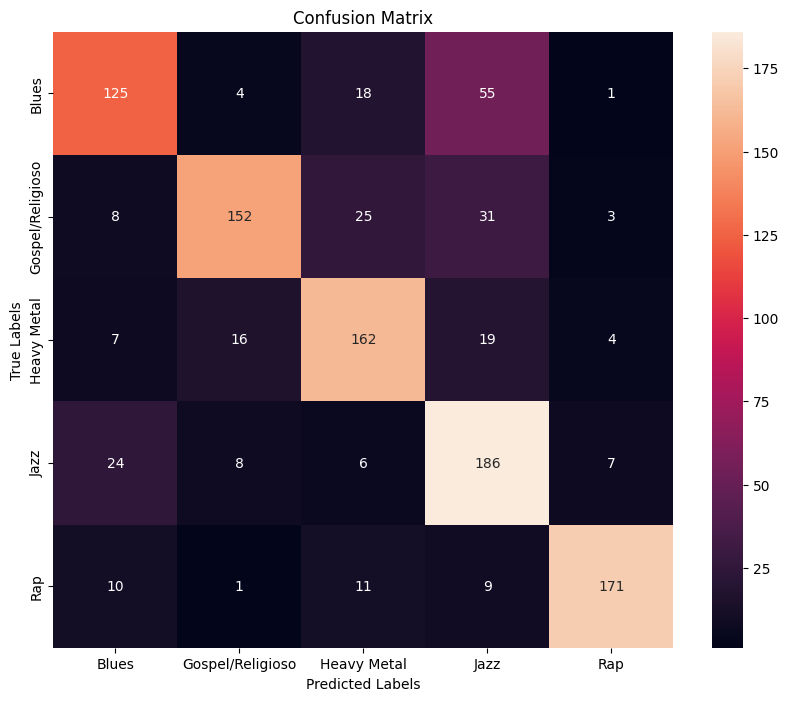

In [53]:
cm = confusion_matrix(true_labels, predicted_labels)

# Konfusionsmatrix plotten
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [54]:
report = classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_)
print(report)

                  precision    recall  f1-score   support

           Blues       0.72      0.62      0.66       203
Gospel/Religioso       0.84      0.69      0.76       219
     Heavy Metal       0.73      0.78      0.75       208
            Jazz       0.62      0.81      0.70       231
             Rap       0.92      0.85      0.88       202

        accuracy                           0.75      1063
       macro avg       0.77      0.75      0.75      1063
    weighted avg       0.76      0.75      0.75      1063



<a id="9"></a>
## 2. Experiment mit Transformer

Damit man in Kaggle die Daten importieren kann:

In [55]:
# os.listdir("/kaggle/input/")

Für dieses Experiment kopieren wir uns auch erst Mal einen eigenen Dataframe:

In [56]:
experiment_two = min_similarity_df.copy()

Im nächsten Schritt passen wir den Dataframe etwas an:

In [57]:
experiment_two.rename_axis("id", inplace=True)
experiment_two.index = experiment_two.index.astype("int64")
experiment_two.Titel = experiment_two.Titel.astype("string")
experiment_two.Lyric = experiment_two.Lyric.astype("string")
experiment_two.Artist = experiment_two.Artist.astype("string")
experiment_two.Genres = pd.Categorical(experiment_two.Genres)
experiment_two.dropna(inplace=True)
experiment_two.dtypes

Titel              string[python]
Lyric              string[python]
Artist             string[python]
Genres                   category
Lyric_Count                 int64
Count_Norm                float64
Avg_Word_Length           float64
Unique_Words                int64
Genre_Encoded               int32
dtype: object

Wir Encoden die Labels des Dataframes:

In [58]:
unique_genres = pd.unique(experiment_two['Genres'])  # Ensures a consistent order
genre_to_index = {genre: idx for idx, genre in enumerate(unique_genres)}
experiment_two['Genres'] = experiment_two['Genres'].apply(lambda x: genre_to_index[x])

In [59]:
print(experiment_two['Lyric'].apply(type).value_counts())

Lyric
<class 'str'>    10255
Name: count, dtype: int64


Casting des Dataframes in das Huggingface Dataset:

In [60]:


#Hugingface
from datasets import Dataset, ClassLabel, Value


experiment_two.Genres = experiment_two.Genres.cat.codes

dataset = Dataset.from_pandas(experiment_two)
features = dataset.features.copy()
features["Genres"] = ClassLabel(names=unique_genres.tolist())
features["Lyric"] = Value("string")

dataset= dataset.cast(features)
print(dataset)

Casting the dataset: 100%|██████████| 10255/10255 [00:00<00:00, 548987.06 examples/s]

Dataset({
    features: ['Titel', 'Lyric', 'Artist', 'Genres', 'Lyric_Count', 'Count_Norm', 'Avg_Word_Length', 'Unique_Words', 'Genre_Encoded', 'id'],
    num_rows: 10255
})


Tokenization der Lyrics:

In [61]:
def encode(batch):
    # Geht nur Lokal in der Methode
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

    encoded = tokenizer(batch['Lyric'], truncation=True, padding='max_length', max_length=512)
    encoded['labels'] = batch['Genres']
    return encoded

dataset = dataset.map(encode, batched=True, num_proc = 7)

Map (num_proc=7): 100%|██████████| 10255/10255 [00:08<00:00, 1238.55 examples/s]


Split der Daten in Train und Test:

In [62]:
from datasets import DatasetDict


num_labels = len(unique_genres)
train_test_split = dataset.train_test_split(test_size = 0.2)
## adding a validation set
dataset = DatasetDict({
    'train': train_test_split['train'],
    'test': train_test_split['test']
})
print(dataset['train'][0])

{'Titel': 'Baby Get Lost', 'Lyric': 'good mornin baby baby welcome back town yeah doin much travlin woman never know youre gonna around yeah fine mellow baby stubborn mule love like angel baby treat like fool two faced woman dont hand double cross well anytime im ready woman well tell tell baby get lost cheatin outside youre doin evrything chose better come back inside woman cause got much lose dont want trouble baby wanna tell got boss yeah anytime im ready baby oh tell tell baby get lost yes ill try stop cheatin woman dont time got many woman baby till theyre standing line want tell baby yeah know ive got boss right well anytime im ready baby tell baby get lost', 'Artist': 'BB King', 'Genres': 0, 'Lyric_Count': 116, 'Count_Norm': 4.6911764705882355, 'Avg_Word_Length': 4.474137931034483, 'Unique_Words': 65, 'Genre_Encoded': 0, 'id': 20713, 'input_ids': [101, 2204, 22822, 11483, 3336, 3336, 6160, 2067, 2237, 3398, 24341, 2172, 19817, 11431, 4115, 2450, 2196, 2113, 2115, 2063, 6069, 210

Helper-Methode für das erstellen der Confucion-Matrix. Die Methode speichert die Accuracy und die Confucion-Matrix nach jeder Epoche vom Training des Modells:

In [63]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    conf_matrix = confusion_matrix(labels, predictions)
    
    conf_matrix_list = conf_matrix.tolist()  # Convert the NumPy array to a list for JSON serialization during training
    
    return {
        "accuracy": acc,
        "confusion_matrix": conf_matrix_list  # return a combination of confusion matrix and accuracy pro training epoch
    }

Initalisieren des Modells:

In [64]:


from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments


model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels, ignore_mismatched_sizes=True)

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    evaluation_strategy="epoch",     # evaluation strategy to adopt during training
    save_strategy="epoch",           # save strategy
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    report_to="none"
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics = compute_metrics
)

NameError: name '_C' is not defined

Training des Modells:

In [ ]:
trainer.train()
results = trainer.evaluate()
print(results)

Plotting voin Training und Validation Loss über die Logs des Transformers:

In [ ]:
from transformers import AutoModel, AutoTokenizer

checkpoints_directory = '/kaggle/working/results'

# List all directories starting with 'checkpoint-'
checkpoint_dirs = [d for d in os.listdir(checkpoints_directory) if d.startswith('checkpoint-')]

# Sort the directories by the checkpoint number and get last
sorted_checkpoint_dirs = sorted(checkpoint_dirs, key=lambda x: int(x.split('-')[-1]))
latest_checkpoint = sorted_checkpoint_dirs[-1]
model = AutoModel.from_pretrained(os.path.join(checkpoints_directory, latest_checkpoint))

# Load the tokenizer from the latest checkpoint
tokenizer = AutoTokenizer.from_pretrained(os.path.join(checkpoints_directory, latest_checkpoint))

# Load the trainer state
trainer_state_path = os.path.join(checkpoints_directory, latest_checkpoint, 'trainer_state.json')
with open(trainer_state_path, 'r') as file:
    trainer_state = json.load(file)

# Initialize lists to store the metrics
training_losses = []
validation_losses = []
accuracies = []
steps = []

# Loop through the log history and extract metrics
for entry in trainer_state['log_history']:
    # Collecting training loss and steps - loss is reported many times within an epoch
    if 'loss' in entry and 'step' in entry:
        training_losses.append(entry['loss'])
        steps.append(entry['step'])
        
    # Collecting validation loss and accuracies - these are reported once per epoch
    if 'eval_loss' in entry and 'eval_accuracy' in entry:
        validation_losses.append(entry['eval_loss'])
        accuracies.append(entry['eval_accuracy'])

# Plotting the metrics
plt.figure(figsize=(14, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(steps, training_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

# Since validation loss and accuracies are per epoch
# we use the number of epochs for the x-axis.
epochs = range(1, len(validation_losses) + 1)

# Plot validation loss and accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, validation_losses, label='Validation Loss', color='red')
plt.plot(epochs, accuracies, label='Accuracy', color='green')
plt.title('Validation Loss & Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

plt.tight_layout()
plt.show()

Erstellen einer Confucion Matrix:

In [ ]:
# plot the predictions into a confusion matrix already created in the compute metric method
conf_matrix = results['eval_confusion_matrix']

index_to_genre = {index: genre for index, genre in enumerate(unique_genres)}

# Map the indices in the confusion matrix to genre names
genre_names = [index_to_genre[i] for i in range(len(unique_genres))]

plt.figure(figsize=(15,10))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=genre_names, yticklabels=genre_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Accuracy auf die Testdaten:

In [ ]:
results['eval_accuracy']

<a id="10"></a>
## 3. Experiment mit KNN

Wir kopieren als erstes zwei Datensätze:

In [ ]:
experiment_three_a = min_similarity_df.copy()
experiment_three_b = max_similarity_df.copy()

TO-DO: Herbert Kommentieren:

In [ ]:
# Ensure NLTK resources are downloaded
nltk.download('stopwords', quiet=True)

def remove_repetitions(text):
    words = text.split()
    return ' '.join(sorted(set(words), key=words.index))

def clean_lyrics(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    stop_words = set(stopwords.words('english'))
    return ' '.join(word for word in text.split() if word not in stop_words)

def get_sentiment(text):
    # Calculate sentiment polarity using TextBlob
    return TextBlob(text).sentiment.polarity

def train_genre_classifier(df, class_balance = True, print = True):
    if class_balance == True:
        genre_counts = df['Genres'].value_counts()
        smallest_size = genre_counts.min()
        df_sampled = df.groupby('Genres').sample(n = smallest_size, random_state=SEED)
    else:
        df_sampled = df

    # Conversion to string
    df_sampled.loc[:, 'Titel'] = df_sampled['Titel'].astype(str)
    df_sampled.loc[:, 'Lyric'] = df_sampled['Lyric'].astype(str)
    df_sampled.loc[:, 'Artist'] = df_sampled['Artist'].astype(str)

    # Clean lyrics and calculate sentiment
    df_sampled.loc[:, 'Lyric'] = df_sampled['Lyric'].apply(clean_lyrics)
    df_sampled.loc[:, 'sentiment'] = df_sampled['Lyric'].apply(get_sentiment)

    # Count the number of words in the 'Lyric' column and normalize
    df_sampled.loc[:, 'lyric_count'] = df_sampled['Lyric'].str.split().str.len()
    df_sampled.loc[:, 'lyric_count_norm'] = df_sampled['lyric_count'] / df_sampled['lyric_count'].max()

    # Encoding labels

    df_sampled.loc[:, 'label'] = label_encoder.fit_transform(df_sampled['Genres'])

    # Preprocessing and vectorization of text data
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X_text = vectorizer.fit_transform(df_sampled['Lyric'])

    # Adding the normalized lyric count and sentiment as features
    X_numeric = df_sampled[['lyric_count_norm', 'sentiment']].values

    # Combining text and numeric features
    X_combined = hstack([X_text, X_numeric])
    # Labels
    y = df_sampled['Genres']

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=SEED)

    # Apply SMOTE for class balancing in the training set
    smote = SMOTE(random_state=SEED)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Model training
    model = RandomForestClassifier(n_estimators=100, random_state=SEED)
    model.fit(X_train_resampled, y_train_resampled)
    
    # Model evaluation
    predictions = model.predict(X_test)
    if print == True:

        print(classification_report(y_test, predictions))
        print(f'Accuracy: {accuracy_score(y_test, predictions):.2f}')

    return np.round(accuracy_score(y_test, predictions)*100,1)

Kommentieren Herbert:

In [ ]:
# Initialize DataFrame to store results
results_df = pd.DataFrame(columns=['Configuration','Accuracy'])

def add_result(configuration, accuracy):
    global results_df
    new_row = pd.DataFrame({
        'Configuration': [configuration],
        'Accuracy': [accuracy]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# Train and evaluate the classifier under different conditions
add_result('Min Similarity No Balance', train_genre_classifier(min_similarity_df, class_balance=False, print = False))
add_result('Max Similarity No Balance', train_genre_classifier(max_similarity_df, class_balance=False, print = False))
add_result('Min Similarity With Balance', train_genre_classifier(min_similarity_df, class_balance=True, print = False))
add_result('Max Similarity With Balance', train_genre_classifier(max_similarity_df, class_balance=True, print = False))

# Print results
print("Accuracy Results:")
print(results_df)



<a id="11"></a>
## Fazit

TO-DO Modelle vergleichen